# 중고차 데이터 품질 및 시각화 분석 (Professional Data Quality Analysis)

이 노트북은 중고차 데이터의 본질과 품질을 시각화하는 데 집중합니다. 모델링 단계를 생략하고, 데이터의 분포, 상관관계, 이상치 및 합성 데이터와의 비교 가능성을 심층적으로 분석합니다.

## 1. 환경 설정 및 스타일
발표용으로 적합한 폰트 사이즈와 한글 깨짐 방지 설정을 적용합니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew, kurtosis

warnings.filterwarnings('ignore')

# 시각화 스타일 설정 (발표용 고해상도 및 폰트 설정)
plt.style.use('ggplot')
sns.set_palette('muted')

# 한글 깨짐 방지 설정 (Windows용 Malgun Gothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 발표용 폰트 사이즈 확대
plt.rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 20, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

## 2. 데이터 로드 및 전처리
수치형 컬럼 중 가격(price)과 주행거리(milage)가 문자열로 되어 있는 경우 수치형으로 변환합니다.

In [3]:
# 데이터 로드
df = pd.read_csv(r'C:\Users\subin\github\used_cars.csv')

def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

def clean_milage(x):
    if isinstance(x, str):
        return float(x.replace(' mi.', '').replace(',', ''))
    return x

# 전처리 적용
df['price'] = df['price'].apply(clean_currency)
df['milage'] = df['milage'].apply(clean_milage)

print("데이터 로드 완료. 샘플 데이터:")
display(df.head())
print("데이터 타입 정보:")
display(df.dtypes)

데이터 로드 완료. 샘플 데이터:


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598.0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500.0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999.0


데이터 타입 정보:


brand            object
model            object
model_year        int64
milage          float64
fuel_type        object
engine           object
transmission     object
ext_col          object
int_col          object
accident         object
clean_title      object
price           float64
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   float64
 4   fuel_type     3839 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      3896 non-null   object 
 10  clean_title   3413 non-null   object 
 11  price         4009 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 376.0+ KB


## 3. 데이터 개요 및 분포 분석 (KDE & Histogram)
수치형 변수의 왜도(Skewness)와 첨도(Kurtosis)를 확인하여 데이터의 분포 특성을 파악합니다.

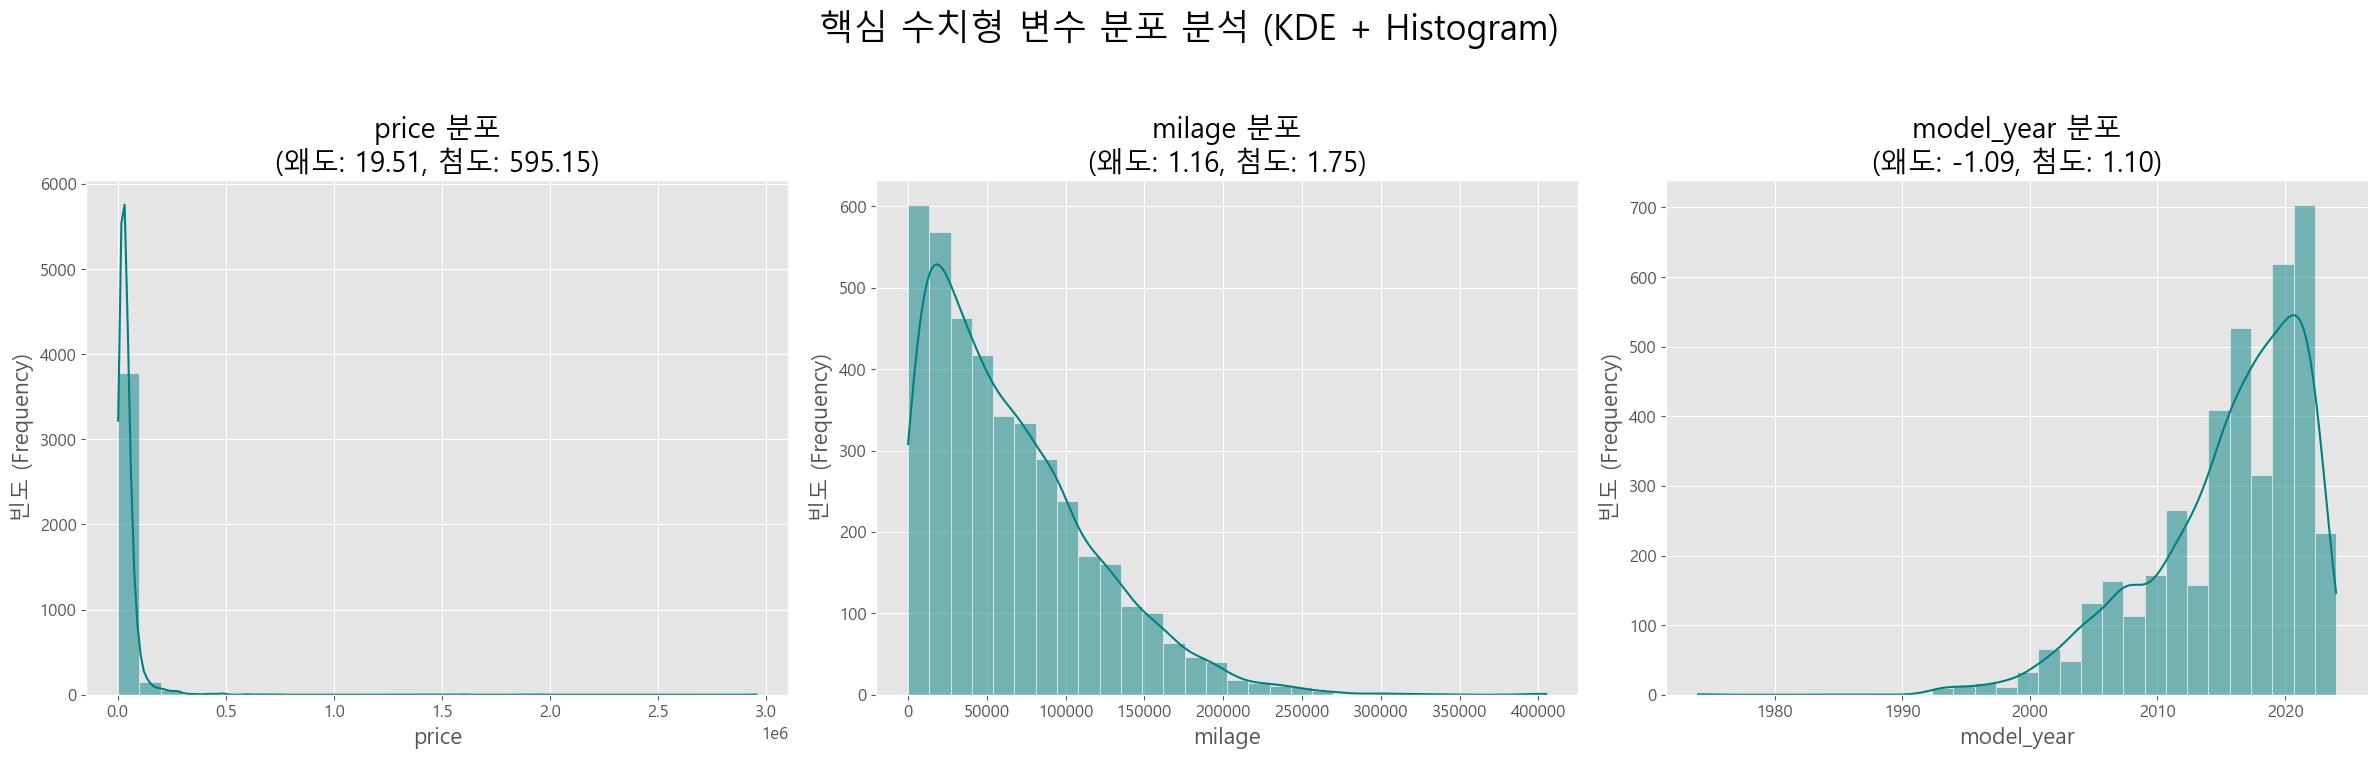

In [4]:
num_cols = ['price', 'milage', 'model_year']

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('핵심 수치형 변수 분포 분석 (KDE + Histogram)', fontsize=25)

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='teal', bins=30)
    s = skew(df[col].dropna())
    k = kurtosis(df[col].dropna())
    axes[i].set_title(f'{col} 분포\n(왜도: {s:.2f}, 첨도: {k:.2f})')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('빈도 (Frequency)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 인사이트: 왜도가 높은 경우 특정 가격대나 주행거리에 데이터가 쏠려 있음을 의미합니다.
# 이는 향후 합성 데이터 생성 시 모델이 복제해야 할 핵심적인 분포 특징입니다.

## 4. 상관관계 및 의존성 분석
변수 간의 상관계수를 시각화하고 타겟(price)과 연관이 깊은 변수를 파악합니다.

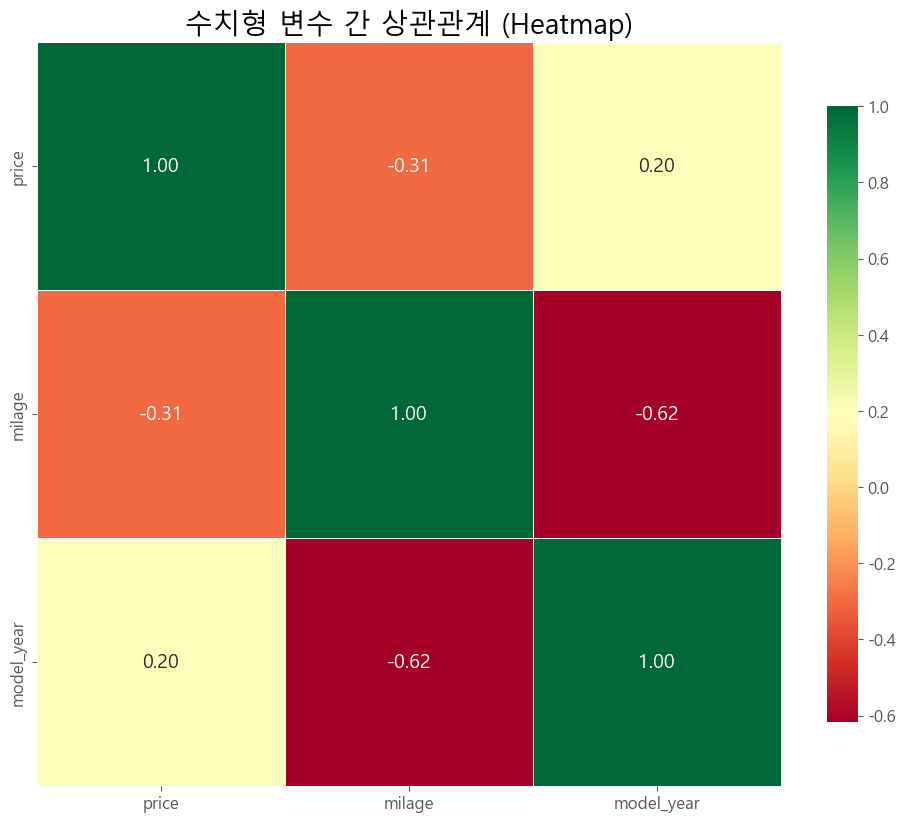

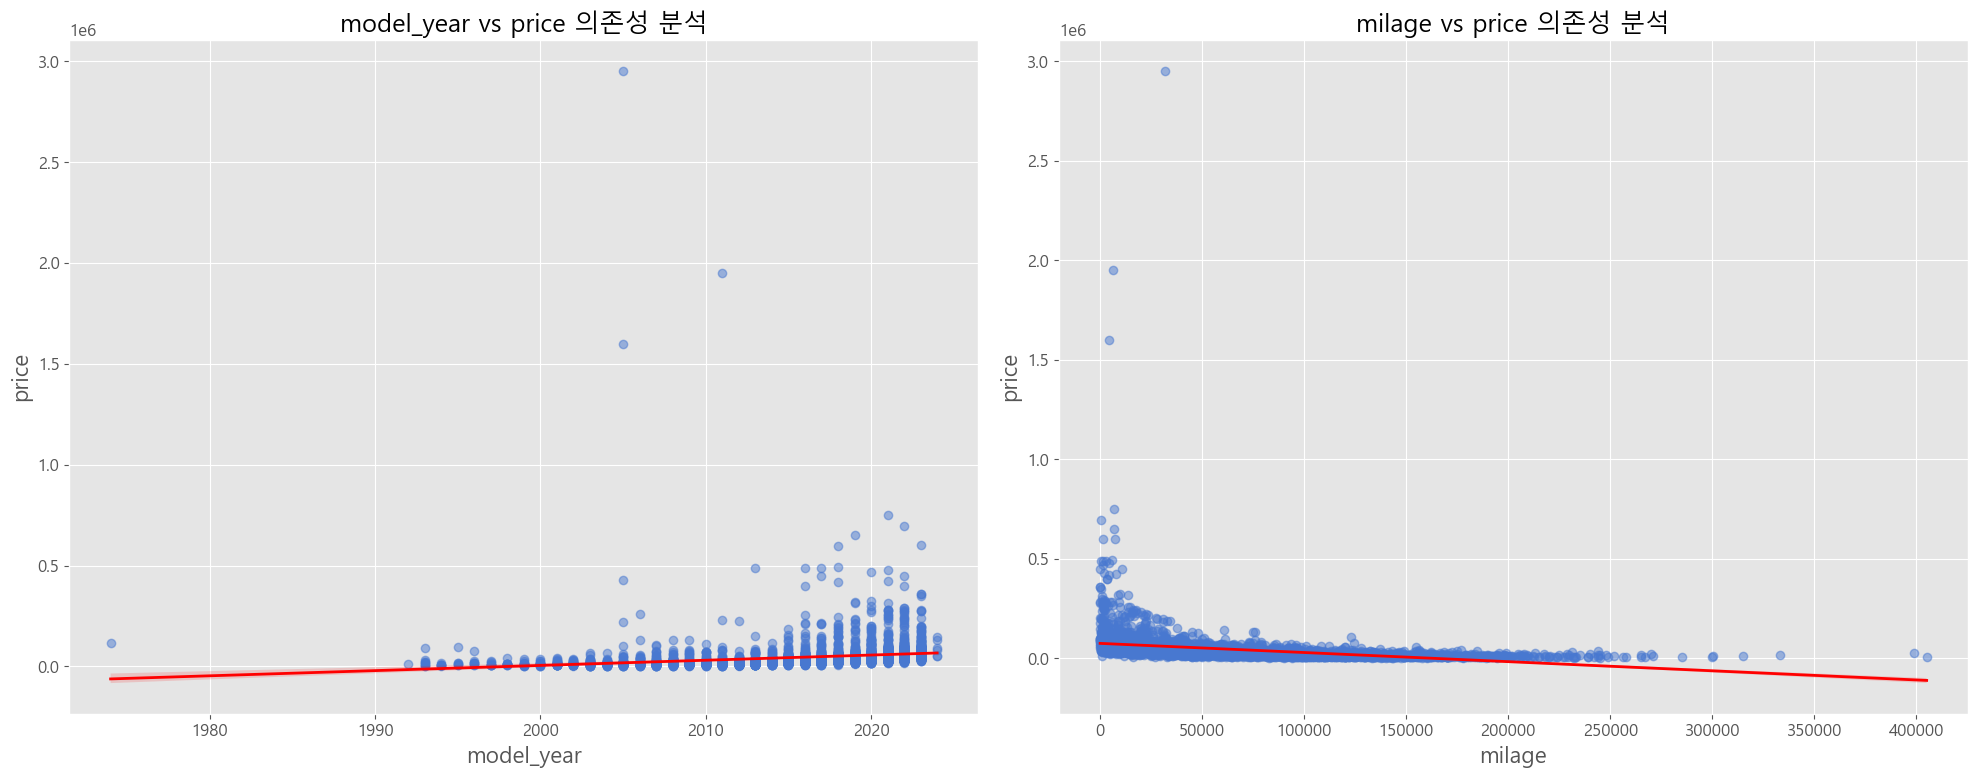

In [5]:
# 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', square=True, linewidths=.5, cbar_kws={'shrink': .8})
plt.title('수치형 변수 간 상관관계 (Heatmap)', fontsize=20)
plt.show()

# 타겟(price)과 가장 상관관계가 높은 변수 시각화
target = 'price'
top_3_corr = corr[target].sort_values(ascending=False).index[1:4]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, col in enumerate(top_3_corr[:2]): # 상위 2개 시각화 예시
    sns.regplot(data=df, x=col, y=target, ax=axes[i], line_kws={'color':'red', 'lw':2}, scatter_kws={'alpha':0.5})
    axes[i].set_title(f'{col} vs {target} 의존성 분석', fontsize=18)

plt.tight_layout()
plt.show()

# 인사이트: 상관계수가 명확한 변수들은 데이터의 본질적인 인과관계를 설명합니다.
# 이전 데이터셋과 비교했을 때 상관관계가 뚜렷하다면 데이터의 품질이 높다고 평가할 수 있습니다.

## 5. 이상치(Outlier) 집중 분석
박스 플롯을 통해 이상치를 식별하고, 비정상적인 데이터를 강조합니다.

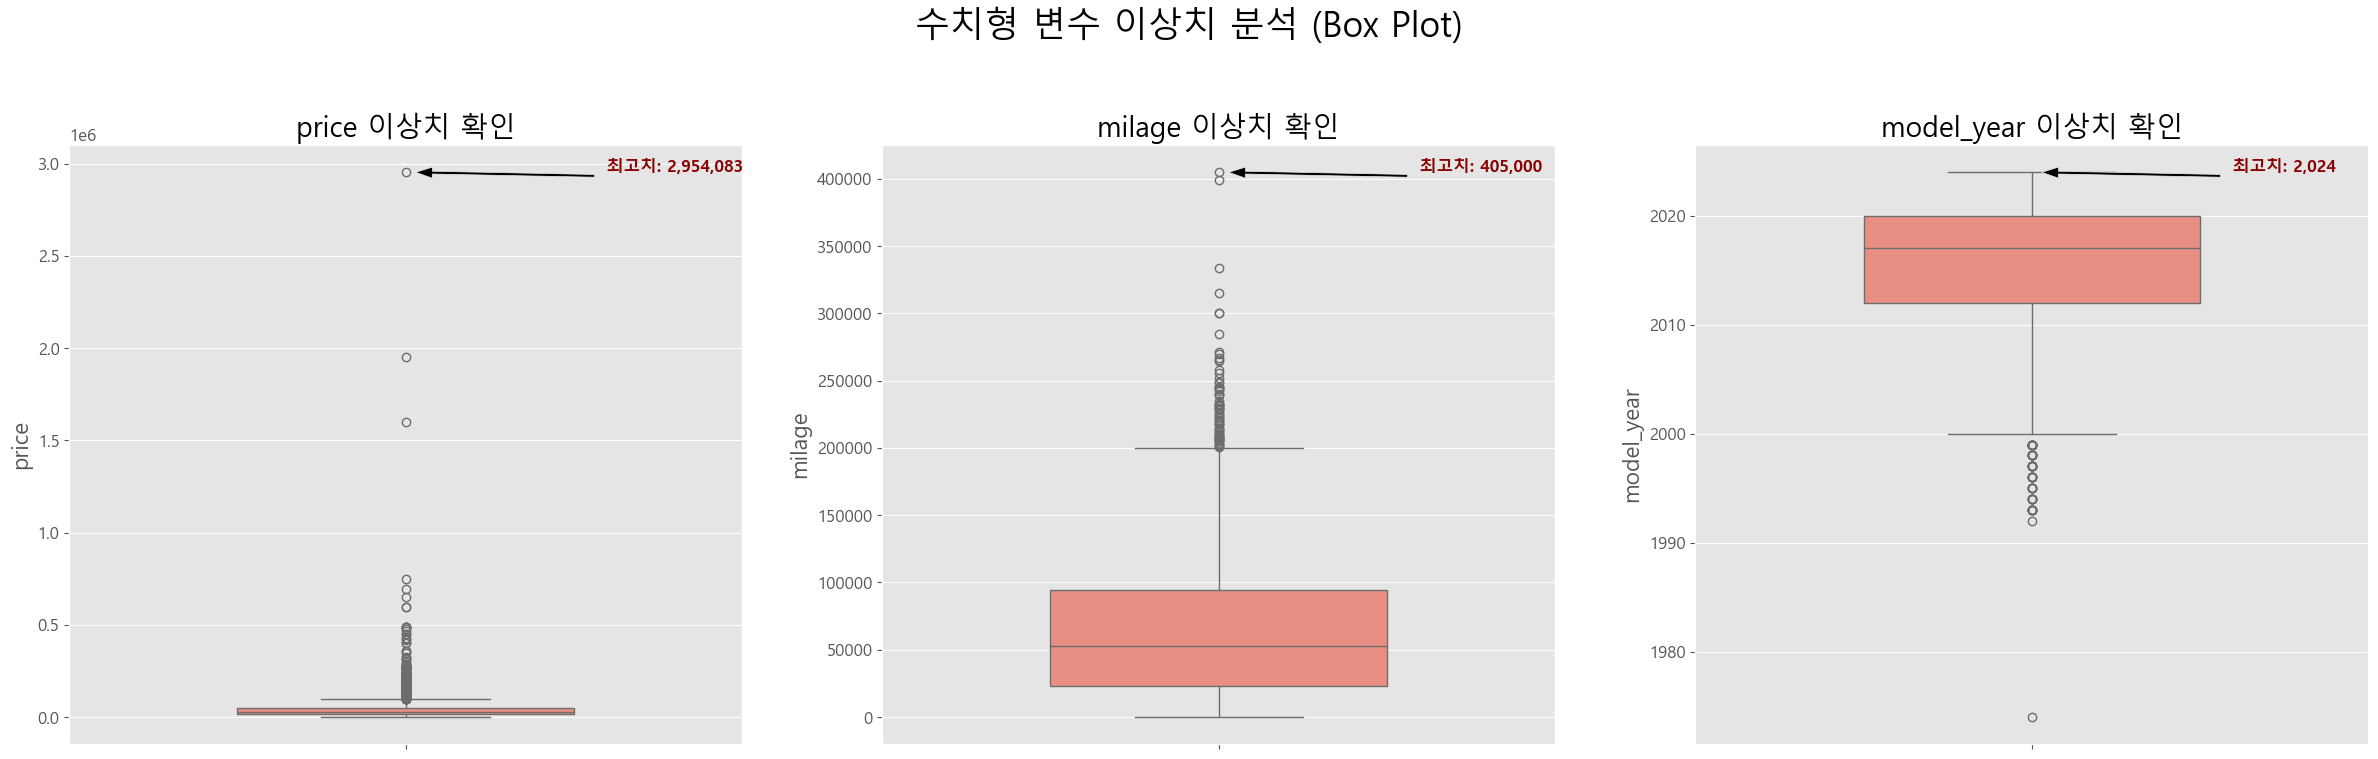

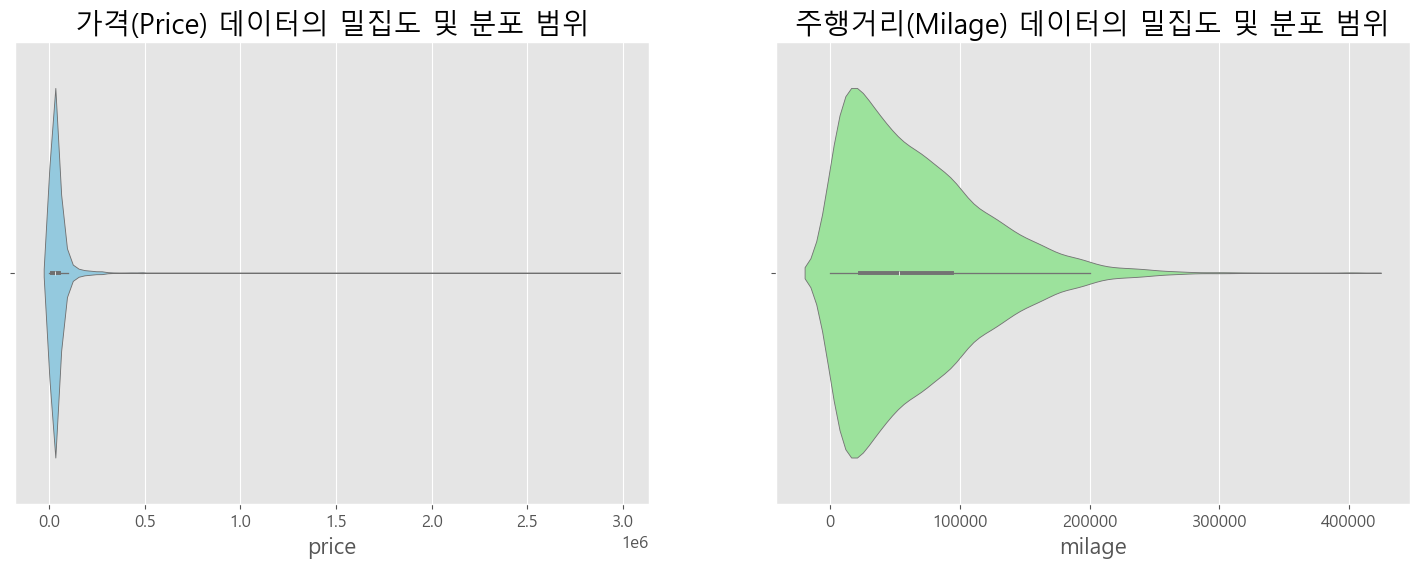

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('수치형 변수 이상치 분석 (Box Plot)', fontsize=25)

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='salmon', width=0.5)
    axes[i].set_title(f'{col} 이상치 확인')
    
    # 터무니없는 이상치 강조 (예: 가격이 상위 0.1%인 경우)
    threshold = df[col].quantile(0.999)
    outliers = df[df[col] >= threshold]
    if not outliers.empty:
        val = outliers[col].max()
        axes[i].annotate(f'최고치: {val:,.0f}', xy=(0, val), xytext=(0.3, val),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                         fontsize=12, fontweight='bold', color='darkred')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Violin Plot을 통한 비중 분석
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='price', data=df, color='skyblue')
plt.title('가격(Price) 데이터의 밀집도 및 분포 범위')

plt.subplot(1, 2, 2)
sns.violinplot(x='milage', data=df, color='lightgreen')
plt.title('주행거리(Milage) 데이터의 밀집도 및 분포 범위')

plt.show()

# 인사이트: 이상치는 데이터 정제 과정에서 제거되어야 하는 '노이즈'일 수도 있고,
# 희귀 차량(럭셔리 카) 같은 중요한 '정보'일 수도 있습니다. 바이올린 플롯은 이를 동시에 보여줍니다.

In [10]:
# 1. 가격(price) 이상치 추출 (상위 0.1%)
price_threshold = df['price'].quantile(0.999)
price_outliers = df[df['price'] >= price_threshold]

# 2. 주행거리(milage) 이상치 추출 (상위 0.1%)
milage_threshold = df['milage'].quantile(0.999)
milage_outliers = df[df['milage'] >= milage_threshold]

# 결과 확인
print(f"가격 이상치 개수: {len(price_outliers)}")
print(f"주행거리 이상치 개수: {len(milage_outliers)}")

# 샘플 출력
display(price_outliers.head())

가격 이상치 개수: 5
주행거리 이상치 개수: 5


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
229,Bugatti,Veyron 16.4 Grand Sport,2011,6330.0,Gasoline,8.0L W16 64V GDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,White,White,None reported,Yes,1950995.0
624,Rolls-Royce,Cullinan,2022,398.0,Gasoline,6.7L V12 48V GDI DOHC Twin Turbo,8-Speed Automatic,Silver,Charles Blue,None reported,Yes,695000.0
693,Maserati,Quattroporte Base,2005,32000.0,Gasoline,394.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Red,Beige,At least 1 accident or damage reported,Yes,2954083.0
1356,Lamborghini,Aventador SVJ Base,2021,6987.0,Gasoline,6.5L V12 48V MPFI DOHC,7-Speed,–,Nero Ade,None reported,Yes,749950.0
3046,Porsche,Carrera GT Base,2005,4400.0,Gasoline,605.0HP 5.7L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gray,Black,None reported,Yes,1599000.0


In [13]:
# 가격 기준 내림차순 정렬하여 상위 20개 출력
top_price_cars = df.sort_values(by='price', ascending=False).head(10)

# 주요 컬럼들만 선택해서 보기 편하게 출력
print(top_price_cars[['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'price']])

            brand                    model  model_year   milage fuel_type  \
693      Maserati        Quattroporte Base        2005  32000.0  Gasoline   
229       Bugatti  Veyron 16.4 Grand Sport        2011   6330.0  Gasoline   
3046      Porsche          Carrera GT Base        2005   4400.0  Gasoline   
1356  Lamborghini       Aventador SVJ Base        2021   6987.0  Gasoline   
624   Rolls-Royce                 Cullinan        2022    398.0  Gasoline   
979   Lamborghini       Aventador SVJ Base        2019   6929.0  Gasoline   
1615  Rolls-Royce                  Phantom        2023   1560.0         –   
1508  Rolls-Royce                  Phantom        2018   7585.0  Gasoline   
3655  Lamborghini         Aventador S Base        2018   5858.0  Gasoline   
1061        Dodge                Viper GTC        2017   1389.0  Gasoline   

                                             engine      price  
693    394.0HP 4.2L 8 Cylinder Engine Gasoline Fuel  2954083.0  
229                8.0